In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
file_path = "RAG_Evaluation_Report.xlsx"   # update path if needed
sheets = ["K3", "K7", "K14"]
dfs = []

for sheet in sheets:
    df_sheet = pd.read_excel(file_path, sheet_name=sheet)

    # Standardize column names
    df_sheet.columns = (
        df_sheet.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )

    # Fix merged cells → forward fill
    df_sheet["evaluation_cases"] = df_sheet["evaluation_cases"].ffill()

    # Keep only required columns
    metrics = ["top_1_accuracy", "precision", "recall", "f1_score"]
    df_sheet = df_sheet[["evaluation_cases", "method", "number_of_samples"] + metrics]

    # Add sheet name tag (optional, for traceability)
    df_sheet["source_sheet"] = sheet

    dfs.append(df_sheet)

In [48]:
# --------------------------------------------------------
# 2. COMBINE ALL SHEETS INTO ONE DATAFRAME
# --------------------------------------------------------
df = pd.concat(dfs, ignore_index=True)
print("\nCombined DataFrame:\n", df.head())

# --------------------------------------------------------
# 3. GROUP ONLY BY METHOD (ignore evaluation cases and sheets)
# --------------------------------------------------------
agg_df = df.groupby("method")[metrics].mean().reset_index()

print("\nAggregated Metrics by Method:\n", agg_df)

methods = agg_df["method"].tolist()


Combined DataFrame:
                                     evaluation_cases     method  \
0  Descriptions are embeded without heireachical ...        RAG   
1  Descriptions are embeded without heireachical ...  RAG + LLM   
2  Descriptions are embeded with heireachical con...        RAG   
3  Descriptions are embeded with heireachical con...  RAG + LLM   
4  Another Dataset is used for the evaluation for...        RAG   

   number_of_samples  top_1_accuracy  precision  recall  f1_score source_sheet  
0               1000           0.857     0.7498  0.7498    0.7498           K3  
1               1000           0.859     0.7528  0.7528    0.7528           K3  
2               1000           0.814     0.6871  0.6875    0.6872           K3  
3               1000           0.844     0.7301  0.7301    0.7301           K3  
4               1000           0.542     0.3762  0.3858    0.3792           K3  

Aggregated Metrics by Method:
       method  top_1_accuracy  precision    recall  f1_sco

In [4]:
def plot_metric(metric_name):
    plt.figure(figsize=(10, 5))

    x = np.arange(len(methods))
    values = agg_df[metric_name].tolist()

    plt.bar(x, values)

    plt.xticks(x, methods, rotation=30, ha="right")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title(f"{metric_name.replace('_', ' ').title()} Comparison Across Methods")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

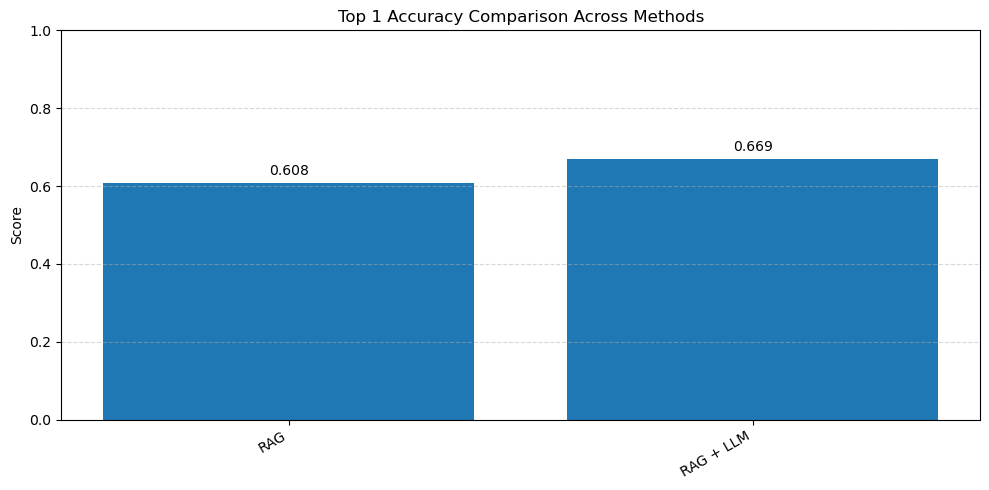

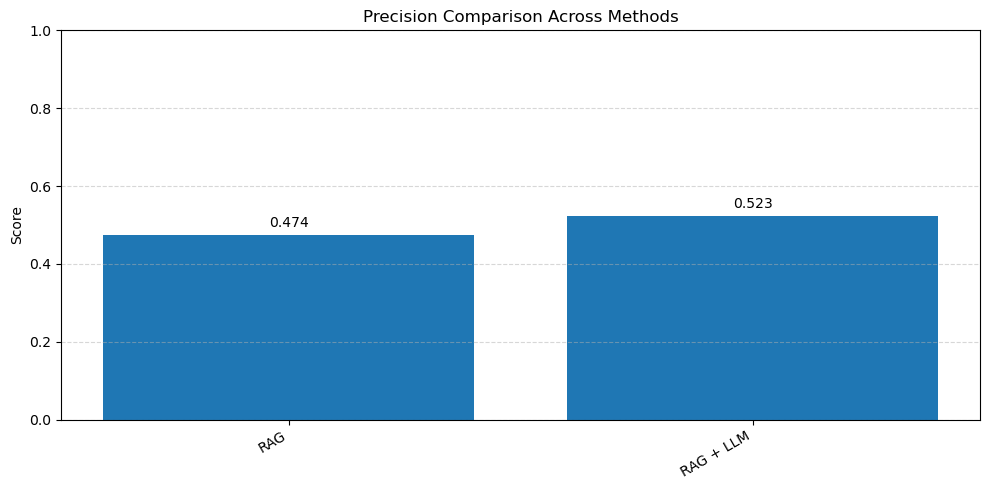

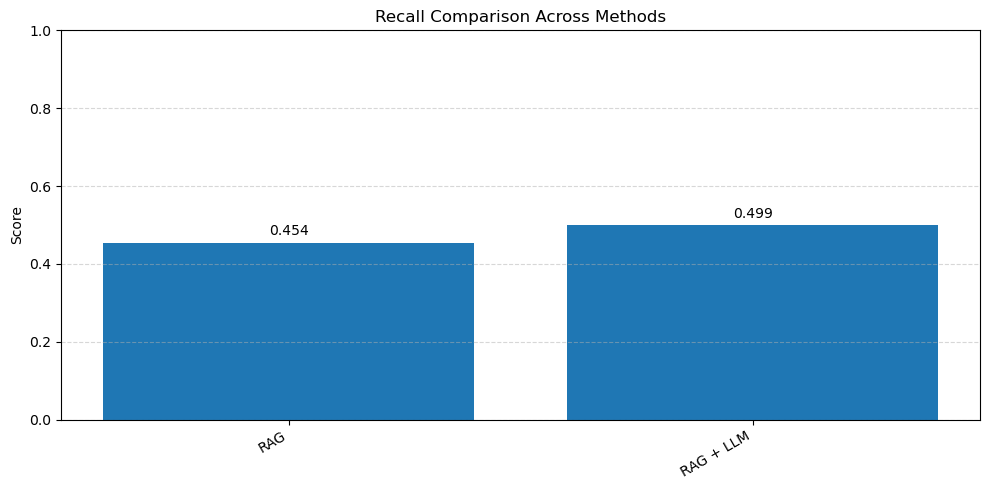

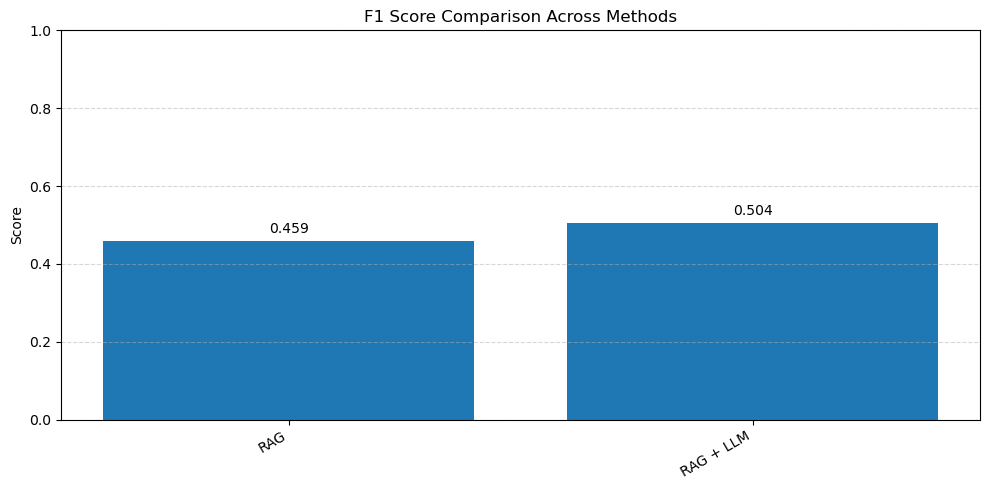

In [49]:
# --------------------------------------------------------
# 5. GENERATE ALL METRIC VISUALIZATIONS
# --------------------------------------------------------
for m in metrics:
    plot_metric(m)

In [ ]:
plt.figure(figsize=(8, 8))

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

for method in agg_df["method"]:
    vals = agg_df[agg_df["method"] == method][["top_1_accuracy","precision","recall","f1_score"]].values.flatten().tolist()
    vals += vals[:1]
    plt.polar(angles, vals, marker='o', label=method)

plt.xticks(angles[:-1], metrics)
plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"])
plt.title("Performance Radar Chart (RAG vs RAG+LLM vs Agentic)")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

In [ ]:
# Build heatmap matrix (methods × metrics)
heatmap_data = agg_df[["top_1_accuracy","precision","recall","f1_score"]].values

plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, cmap="Blues", aspect="auto")

plt.xticks(np.arange(4), ["Top-1","Precision","Recall","F1"])
plt.yticks(np.arange(len(methods)), methods)

plt.colorbar(label="Score")
plt.title("Heatmap of Evaluation Metrics by Method")

for i in range(len(methods)):
    for j in range(4):
        plt.text(j, i, f"{heatmap_data[i, j]:.2f}", ha="center", va="center")

plt.show()

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x="method", y="top_1_accuracy")
plt.title("Distribution of Top-1 Accuracy Across Methods")
plt.show()

In [9]:
# 1. LOAD ALL SHEETS
file_path = "RAG_Evaluation_Report.xlsx"
sheets = ["K3", "K7", "K14"]
metrics = ["top_1_accuracy", "top_k_accuracy", "precision", "recall", "f1_score"]

sheet_dfs = {}

for sheet in sheets:
    df_sheet = pd.read_excel(file_path, sheet_name=sheet)

    # Standardize column names
    df_sheet.columns = (
        df_sheet.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )

    # Fix merged evaluation-case cells (fill down)
    df_sheet["evaluation_cases"] = df_sheet["evaluation_cases"].ffill()

    # Keep only relevant columns
    df_sheet = df_sheet[["evaluation_cases", "method"] + metrics]

    sheet_dfs[sheet] = df_sheet


In [10]:
# --------------------------------------------------------
# 2. RADAR CHART FUNCTION
# --------------------------------------------------------
def plot_radar_for_sheet(df, sheet_name):
    methods = df["method"].unique()

    # Create plot structure
    labels = ["Top-1", "Top-K", "Precision", "Recall", "F1"]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(8, 8))

    for method in methods:
        row = df[df["method"] == method].iloc[0]  # one row per method per sheet
        vals = row[metrics].values.tolist()
        vals += vals[:1]

        plt.polar(angles, vals, marker="o", label=method)

    plt.xticks(angles[:-1], labels)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"])
    plt.title(f"Performance Radar Chart (Sheet: {sheet_name})", fontsize=14)
    plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.15))
    plt.show()


In [ ]:
# --------------------------------------------------------
# 3. GENERATE RADAR CHARTS FOR k3, k7, k14
# --------------------------------------------------------
for sheet in sheets:
    print(f"\nGenerating radar chart for {sheet}...")
    plot_radar_for_sheet(sheet_dfs[sheet], sheet)

Case level visualizaton

In [ ]:

for sheet, k_val in sheet_map.items():
    df = pd.read_excel(file_path, sheet_name=sheet)

    # Standardize & clean
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )

    df["evaluation_cases"] = df["evaluation_cases"].ffill()

    for _, row in df.iterrows():
        all_rows.append({
            "case": row["evaluation_cases"],
            "method": row["method"],
            "k": k_val,
            **{m: row[m] for m in metrics}
        })


In [13]:
sheet_map = {"K3": 3, "K7": 7, "K14": 14}
all_rows = []
case_mapping = {}
case_counter = 1
for sheet, k_val in sheet_map.items():
    df = pd.read_excel(file_path, sheet_name=sheet)

    # Standardize & clean
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )

    df["evaluation_cases"] = df["evaluation_cases"].ffill()

    # Assign case numbers consistently across sheets
    for case in df["evaluation_cases"].unique():
        if case not in case_mapping:
            case_mapping[case] = f"Case {case_counter:02d}"
            case_counter += 1

    # Append rows into unified list
    for _, row in df.iterrows():
        all_rows.append({
            "case": case_mapping[row["evaluation_cases"]],
            "method": row["method"],
            "k": k_val,
            **{m: row[m] for m in metrics}
        })

# Convert to DataFrame
df_all = pd.DataFrame(all_rows)

In [14]:
print("\nCOMBINED DATA ACROSS K VALUES:\n", df_all.head())


COMBINED DATA ACROSS K VALUES:
       case     method  k  top_1_accuracy  top_k_accuracy  precision  recall  \
0  Case 01        RAG  3           0.857           0.880     0.7498  0.7498   
1  Case 01  RAG + LLM  3           0.859           0.880     0.7528  0.7528   
2  Case 02        RAG  3           0.814           0.873     0.6871  0.6875   
3  Case 02  RAG + LLM  3           0.844           0.871     0.7301  0.7301   
4  Case 03        RAG  3           0.542           0.662     0.3762  0.3858   

   f1_score  
0    0.7498  
1    0.7528  
2    0.6872  
3    0.7301  
4    0.3792  


In [45]:
# --------------------------------------------------------
# 2. VISUALIZE PERFORMANCE BY CASE ACROSS K VALUES
# --------------------------------------------------------
cases = df_all["case"].unique()
methods = df_all["method"].unique()

def plot_case(case_name):
    sub = df_all[df_all["case"] == case_name]

    plt.figure(figsize=(12, 6))

    for metric in metrics:
        plt.clf()
        plt.figure(figsize=(12, 6))

        for method in methods:
            method_data = sub[sub["method"] == method].sort_values("k")
            plt.plot(method_data["k"], method_data[metric], marker="o", label=method)

        plt.title(f"{metric.replace('_',' ').title()} Across K Values\nCase: {case_name}")
        plt.xlabel("K Value (Top-K Retrieval)")
        plt.ylabel("Score")
        plt.xticks([3, 7, 14])
        plt.ylim(0, 1)
        plt.grid(linestyle="--", alpha=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [46]:
for case in cases:
    print(f"\nPlotting retrieval performance for case: {case}")
    plot_case(case)


Plotting retrieval performance for case: Case 01


KeyError: 'top1'

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

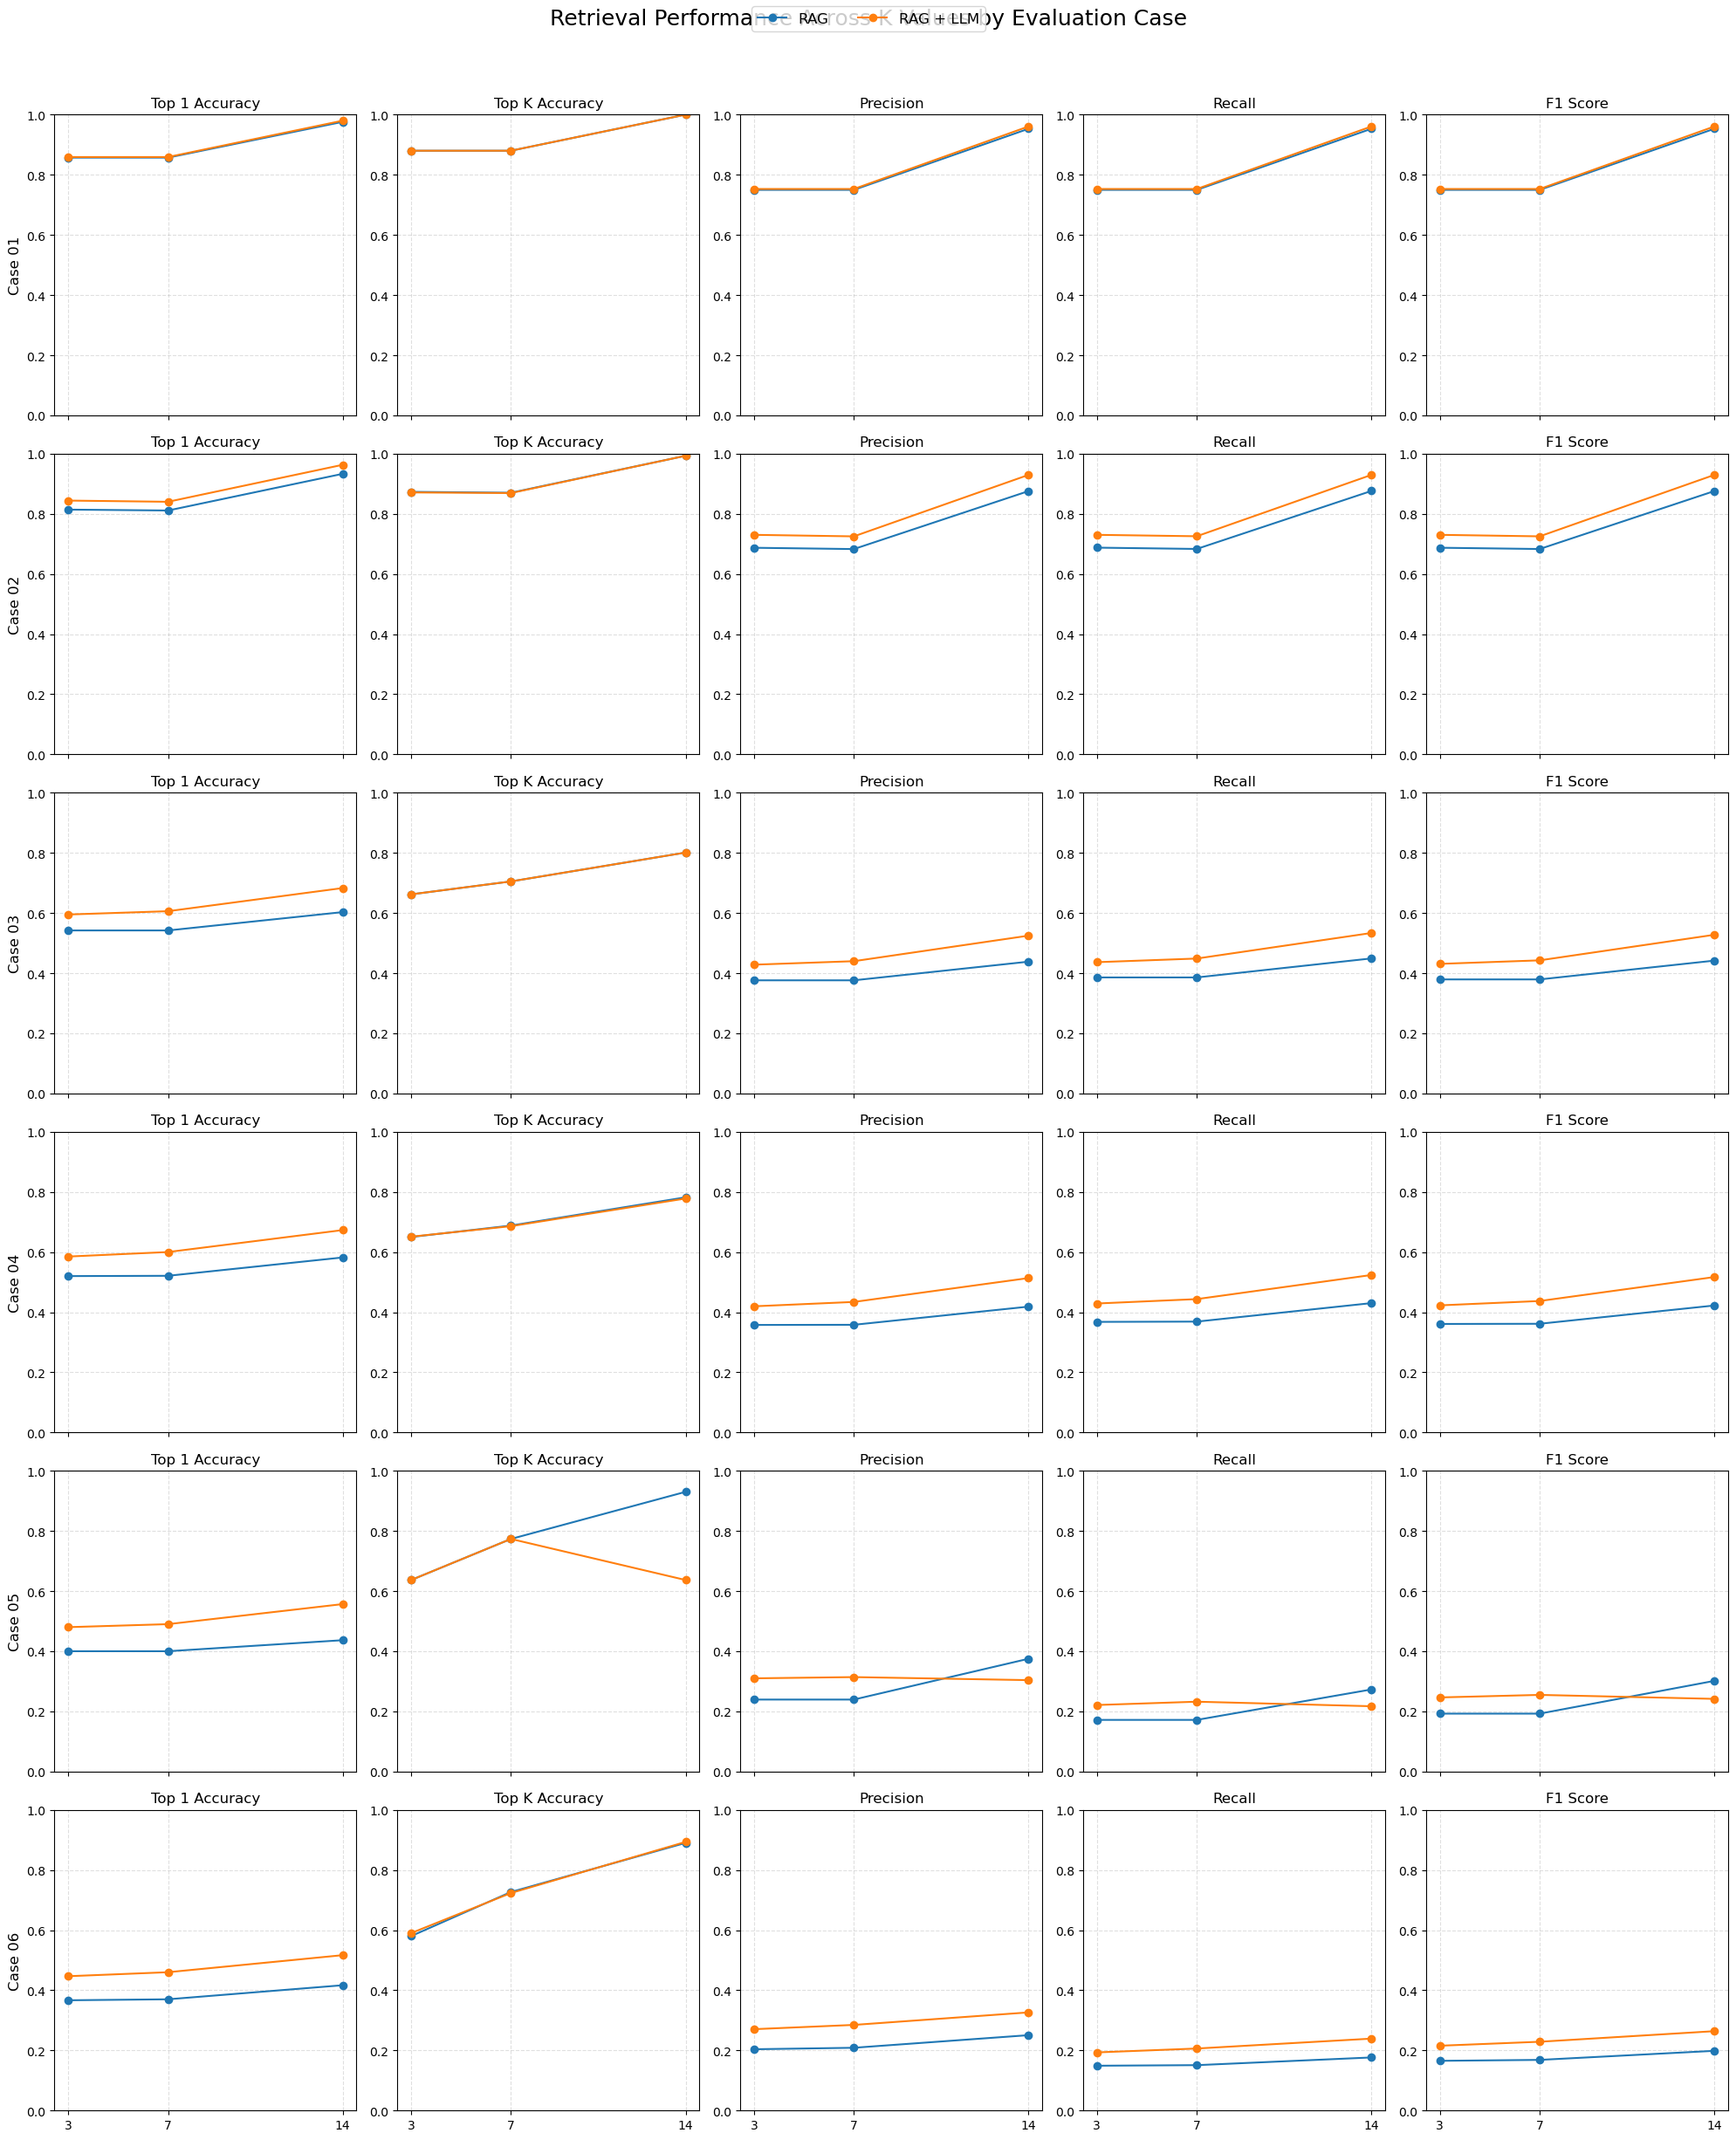

In [17]:
# --------------------------------------------------------
# 2. CREATE COMBINED SUBPLOTS
# --------------------------------------------------------
num_cases = len(cases)
num_metrics = len(metrics)

fig, axes = plt.subplots(num_cases, num_metrics, figsize=(20, 4 * num_cases), sharex=True)

# Ensure axes is always 2D
if num_cases == 1:
    axes = np.array([axes])

for row_idx, case in enumerate(cases):
    case_df = df_all[df_all["case"] == case]

    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]

        # Plot both methods
        for method in methods:
            method_df = case_df[case_df["method"] == method].sort_values("k")
            ax.plot(method_df["k"], method_df[metric], marker="o", label=method)

        # Titles + styling
        ax.set_title(metric.replace("_", " ").title(), fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_xticks([3, 7, 14])
        ax.grid(True, linestyle="--", alpha=0.4)

        # Label case row
        if col_idx == 0:
            ax.set_ylabel(case, fontsize=12)

# Add global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

fig.suptitle("Retrieval Performance Across K Values by Evaluation Case", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

K-sensitive Heatmap

In [18]:
metrics = ["top_1_accuracy", "precision", "recall", "f1_score"]
k_values = [3, 7, 14]
methods = df_all["method"].unique()
cases = sorted(df_all["case"].unique())

In [19]:
df_all.head()

,case,method,k,top_1_accuracy,top_k_accuracy,precision,recall,f1_score
0,Case 01,RAG,3,0.857,0.880,0.7498,0.7498,0.7498
1,Case 01,RAG + LLM,3,0.859,0.880,0.7528,0.7528,0.7528
2,Case 02,RAG,3,0.814,0.873,0.6871,0.6875,0.6872
3,Case 02,RAG + LLM,3,0.844,0.871,0.7301,0.7301,0.7301
4,Case 03,RAG,3,0.542,0.662,0.3762,0.3858,0.3792


In [20]:
def plot_heatmaps_for_method(method_name):
    method_df = df_all[df_all["method"] == method_name]

    fig, axes = plt.subplots(1, len(metrics), figsize=(22, 6))

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Build 2D matrix → rows = cases, columns = K
        heat_data = []
        for case in cases:
            row = []
            for k in k_values:
                val = method_df[(method_df["case"] == case) & (method_df["k"] == k)][metric].values
                row.append(val[0] if len(val) > 0 else np.nan)
            heat_data.append(row)

        heat_data = np.array(heat_data)

        # Heatmap
        im = ax.imshow(heat_data, cmap="Blues", vmin=0, vmax=1)

        ax.set_title(metric.replace("_", " ").title())
        ax.set_xticks(range(len(k_values)))
        ax.set_xticklabels(k_values)
        ax.set_yticks(range(len(cases)))
        ax.set_yticklabels(cases)

        # Add numeric annotations on cells
        for i in range(len(cases)):
            for j in range(len(k_values)):
                ax.text(j, i, f"{heat_data[i, j]:.2f}",
                        ha="center", va="center", color="black")

    fig.suptitle(f"K-Sensitivity Heatmaps for {method_name}", fontsize=18, y=1.02)

    # Add shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label("Score", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_29104\220451439.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


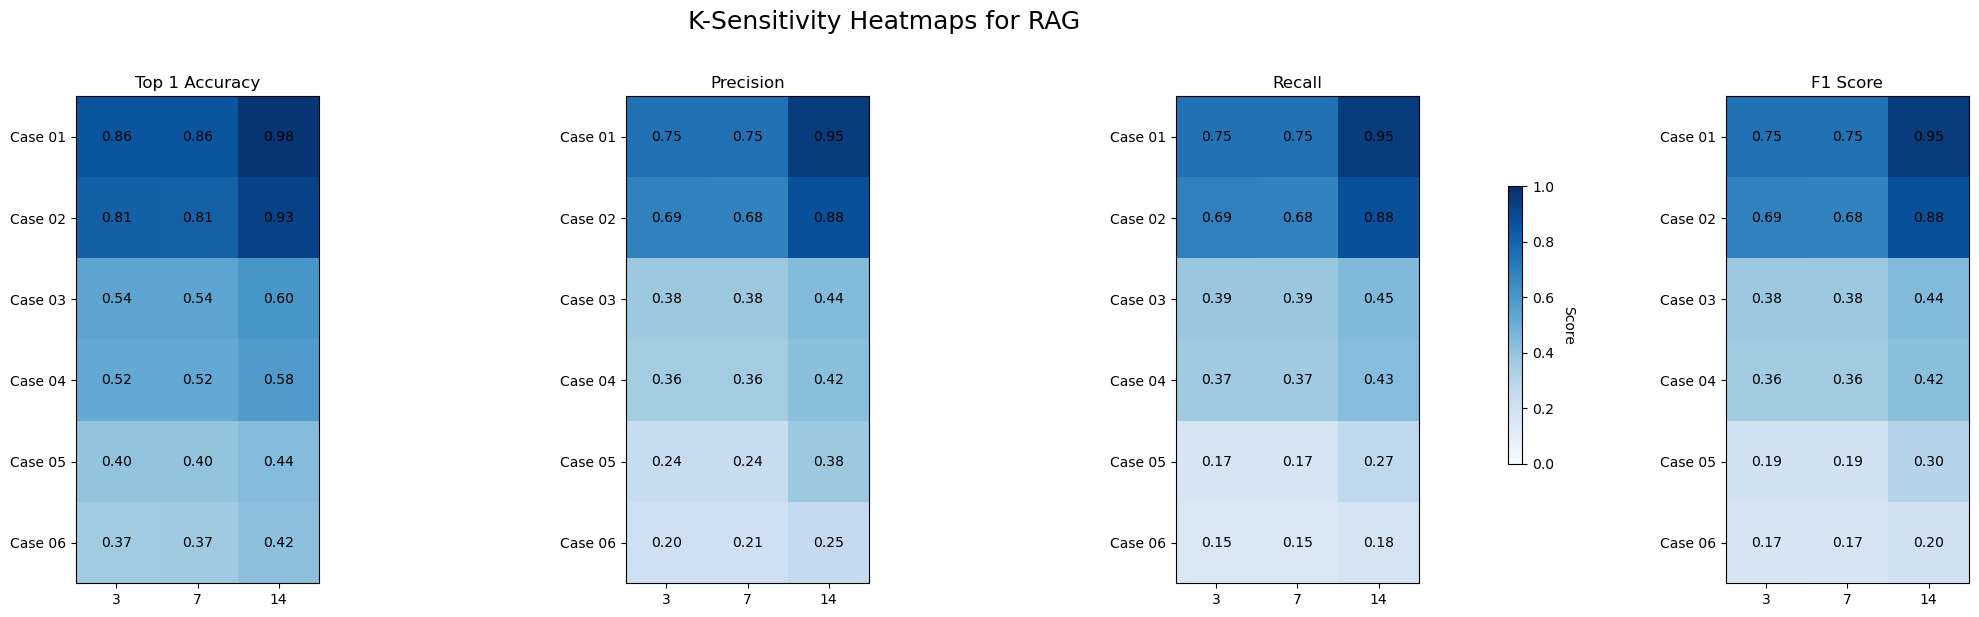

C:\Users\Asus\AppData\Local\Temp\ipykernel_29104\220451439.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


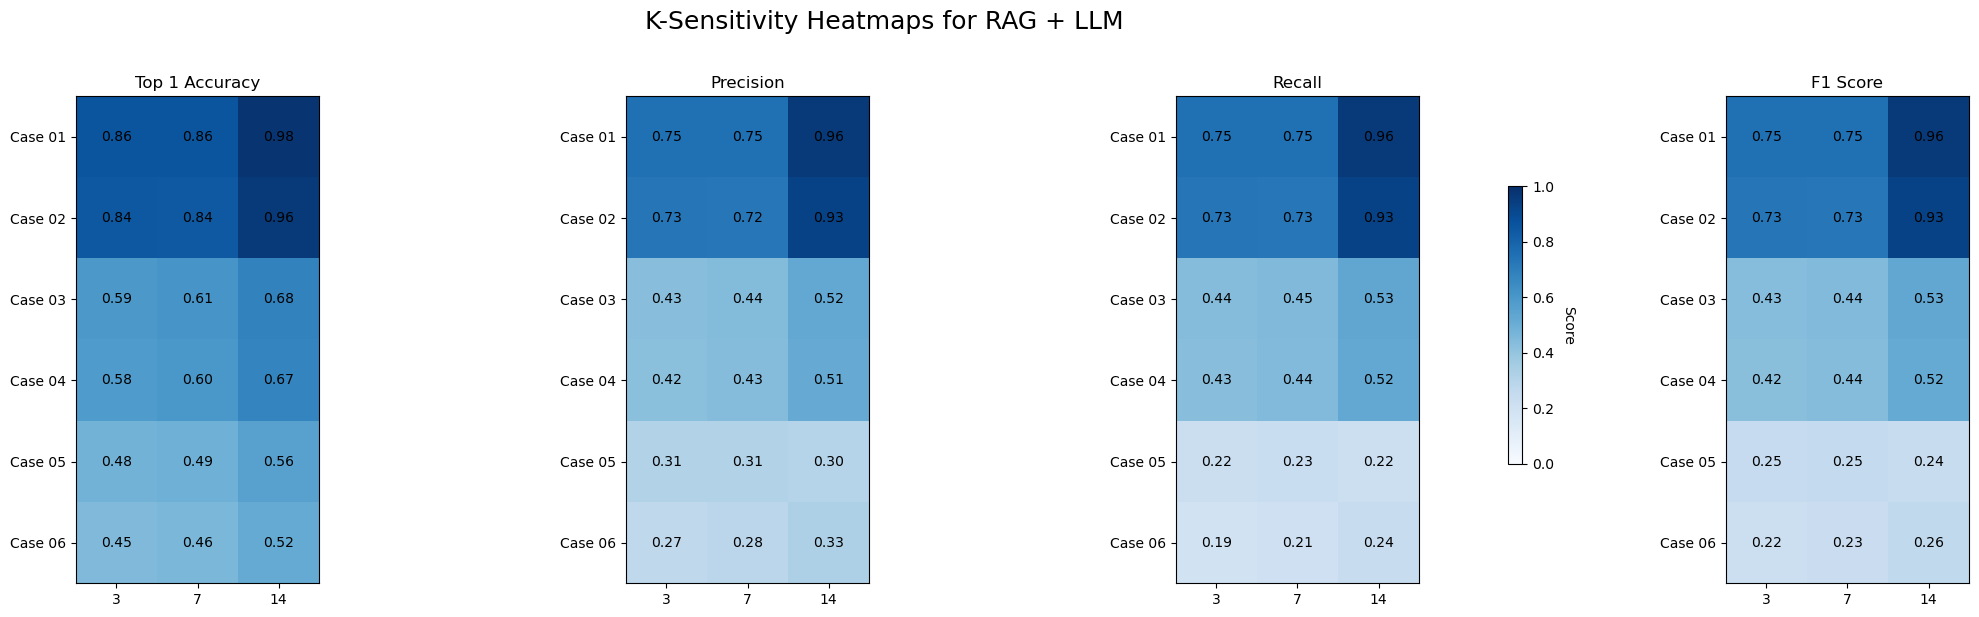

In [21]:
for m in methods:
    plot_heatmaps_for_method(m)

In [22]:
df_all

,case,method,k,top_1_accuracy,top_k_accuracy,precision,recall,f1_score
0,Case 01,RAG,3,0.8570,0.8800,0.7498,0.7498,0.7498
1,Case 01,RAG + LLM,3,0.8590,0.8800,0.7528,0.7528,0.7528
2,Case 02,RAG,3,0.8140,0.8730,0.6871,0.6875,0.6872
3,Case 02,RAG + LLM,3,0.8440,0.8710,0.7301,0.7301,0.7301
4,Case 03,RAG,3,0.5420,0.6620,0.3762,0.3858,0.3792
5,Case 03,RAG + LLM,3,0.5950,0.6620,0.4282,0.4365,0.4309
6,Case 04,RAG,3,0.5200,0.6500,0.3576,0.3678,0.3609
7,Case 04,RAG + LLM,3,0.5850,0.6510,0.4196,0.4289,0.4227
8,Case 05,RAG,3,0.4000,0.6367,0.2393,0.1717,0.1925
9,Case 05,RAG + LLM,3,0.4800,0.6367,0.3099,0.2212,0.2464


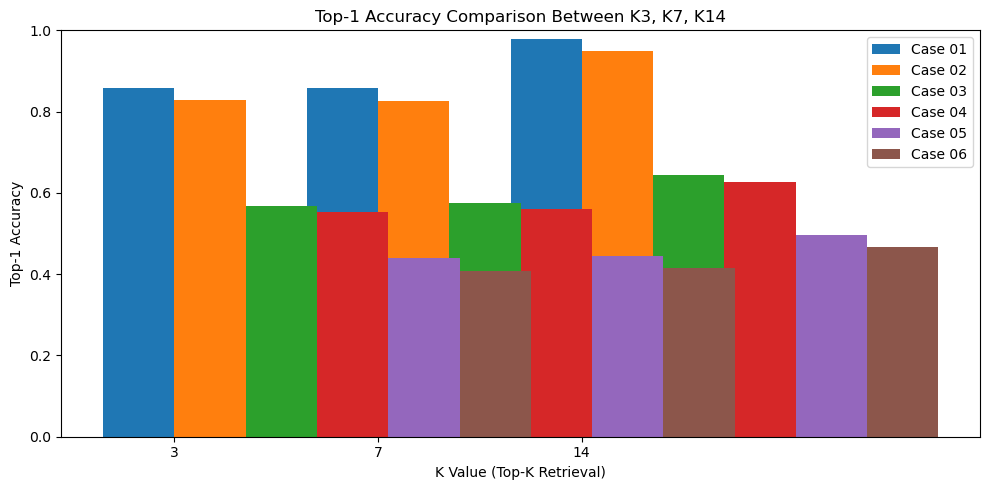

In [23]:
k_vals = [3, 7, 14]

top1_mean = df_all.groupby(["k", "case"])["top_1_accuracy"].mean().unstack()

x = np.arange(len(k_vals))
width = 0.35

plt.figure(figsize=(10,5))

for i, case in enumerate(top1_mean.columns):
    plt.bar(x + (i * width), top1_mean[case], width, label=case)

plt.xticks(x + width/2, k_vals)
plt.ylabel("Top-1 Accuracy")
plt.xlabel("K Value (Top-K Retrieval)")
plt.title("Top-1 Accuracy Comparison Between K3, K7, K14")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
data = {
    "Case": ["Case 01","Case 02","Case 03","Case 04","Case 05","Case 06"],
    "Top1_K3":  [0.857, 0.814, 0.542, 0.520, 0.400, 0.3667],
    "Top1_K7":  [0.857, 0.811, 0.542, 0.521, 0.400, 0.3700],
    "Top1_K14": [0.976, 0.933, 0.603, 0.582, 0.4367, 0.4167]
}

df = pd.DataFrame(data)
df

,Case,Top1_K3,Top1_K7,Top1_K14
0,Case 01,0.8570,0.857,0.9760
1,Case 02,0.8140,0.811,0.9330
2,Case 03,0.5420,0.542,0.6030
3,Case 04,0.5200,0.521,0.5820
4,Case 05,0.4000,0.400,0.4367
5,Case 06,0.3667,0.370,0.4167


# BASE RAG 

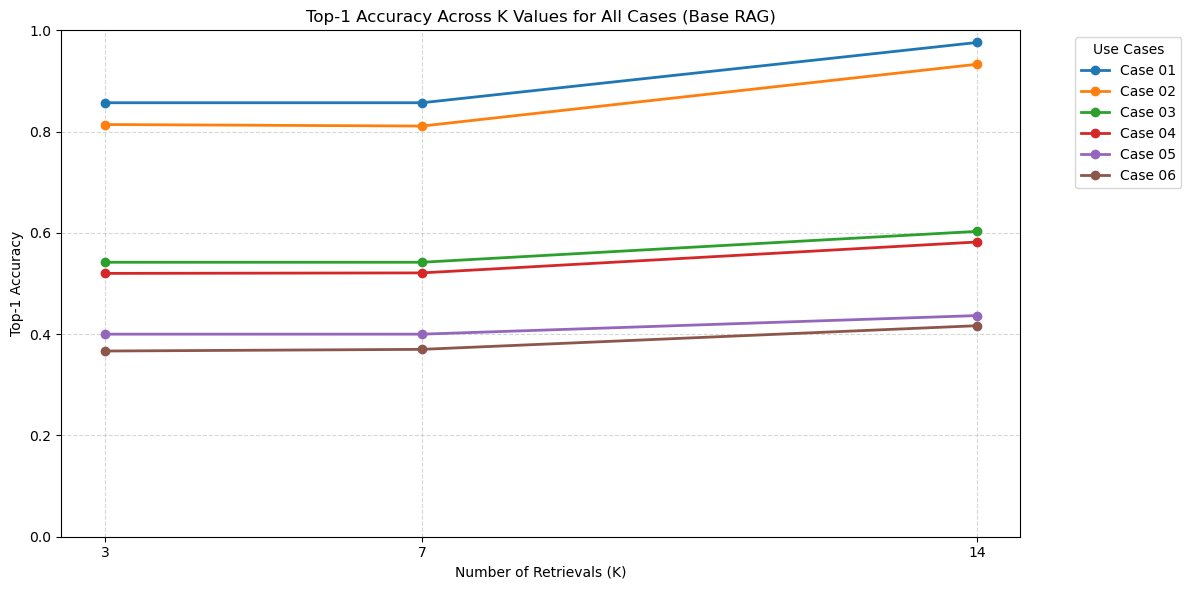

In [25]:
plt.figure(figsize=(12,6))

k_values = [3, 7, 14]

for idx, row in df.iterrows():
    plt.plot(
        k_values,
        [row["Top1_K3"], row["Top1_K7"], row["Top1_K14"]],
        marker="o",
        linewidth=2,
        label=row["Case"]
    )

plt.xticks([3,7,14])
plt.ylim(0,1)
plt.xlabel("Number of Retrievals (K)")
plt.ylabel("Top-1 Accuracy")
plt.title("Top-1 Accuracy Across K Values for All Cases (Base RAG)")
plt.grid(linestyle="--", alpha=0.5)
plt.legend(title="Use Cases", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

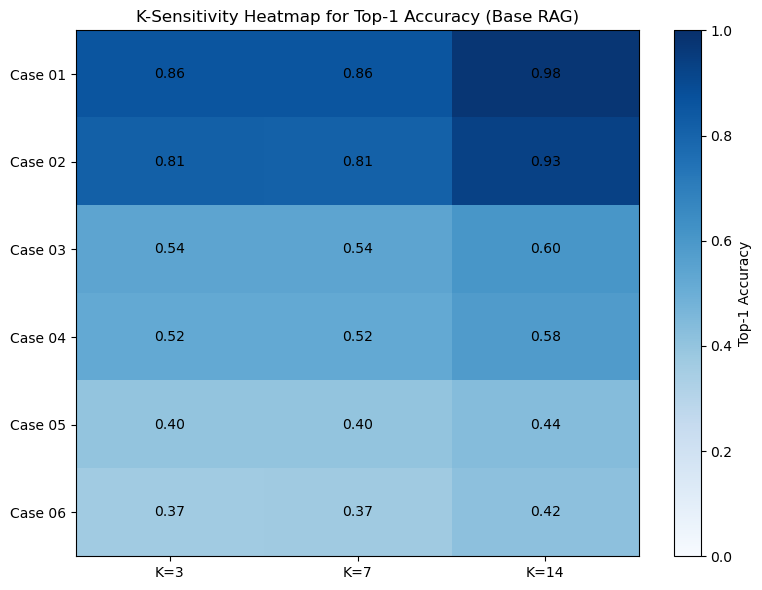

In [26]:
heatmap_data = df[["Top1_K3","Top1_K7","Top1_K14"]].values

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, cmap="Blues", aspect="auto", vmin=0, vmax=1)

plt.xticks([0,1,2], ["K=3","K=7","K=14"])
plt.yticks(range(len(df["Case"])), df["Case"])

plt.colorbar(label="Top-1 Accuracy")
plt.title("K-Sensitivity Heatmap for Top-1 Accuracy (Base RAG)")

# add numeric values inside cells
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        plt.text(j, i, f"{heatmap_data[i,j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()

In [27]:
# ------------------------------------------
# BASE RAG DATA (K3, K7, K14) FOR 6 CASES
# ------------------------------------------

data = {
    "Case 01": {
        "k": [3, 7, 14],
        "top1": [0.857, 0.857, 0.976],
        "top3": [0.88, 0.88, 1.0],
        "precision": [0.7498, 0.7498, 0.9531],
        "recall": [0.7498, 0.7498, 0.9531],
        "f1": [0.7498, 0.7498, 0.9531]
    },
    "Case 02": {
        "k": [3, 7, 14],
        "top1": [0.814, 0.811, 0.933],
        "top3": [0.873, 0.87, 0.993],
        "precision": [0.6871, 0.6828, 0.8756],
        "recall": [0.6875, 0.6832, 0.8761],
        "f1": [0.6872, 0.683, 0.8757]
    },
    "Case 03": {
        "k": [3, 7, 14],
        "top1": [0.542, 0.542, 0.603],
        "top3": [0.662, 0.705, 0.801],
        "precision": [0.3762, 0.3762, 0.4382],
        "recall": [0.3858, 0.3858, 0.449],
        "f1": [0.3792, 0.3792, 0.4417]
    },
    "Case 04": {
        "k": [3, 7, 14],
        "top1": [0.52, 0.521, 0.582],
        "top3": [0.65, 0.3762, 0.782],
        "precision": [0.3576, 0.3581, 0.4185],
        "recall": [0.3678, 0.3687, 0.4302],
        "f1": [0.3609, 0.3615, 0.4223]
    },
    "Case 05": {
        "k": [3, 7, 14],
        "top1": [0.4, 0.4, 0.4367],
        "top3": [0.6367, 0.3858, 0.93],
        "precision": [0.2393, 0.2393, 0.375],
        "recall": [0.1717, 0.1717, 0.2729],
        "f1": [0.1925, 0.1925, 0.3015]
    },
    "Case 06": {
        "k": [3, 7, 14],
        "top1": [0.3667, 0.37, 0.4167],
        "top3": [0.58, 0.3792, 0.89],
        "precision": [0.2039, 0.2088, 0.2507],
        "recall": [0.1491, 0.151, 0.1766],
        "f1": [0.1654, 0.1685, 0.1986]
    },
}

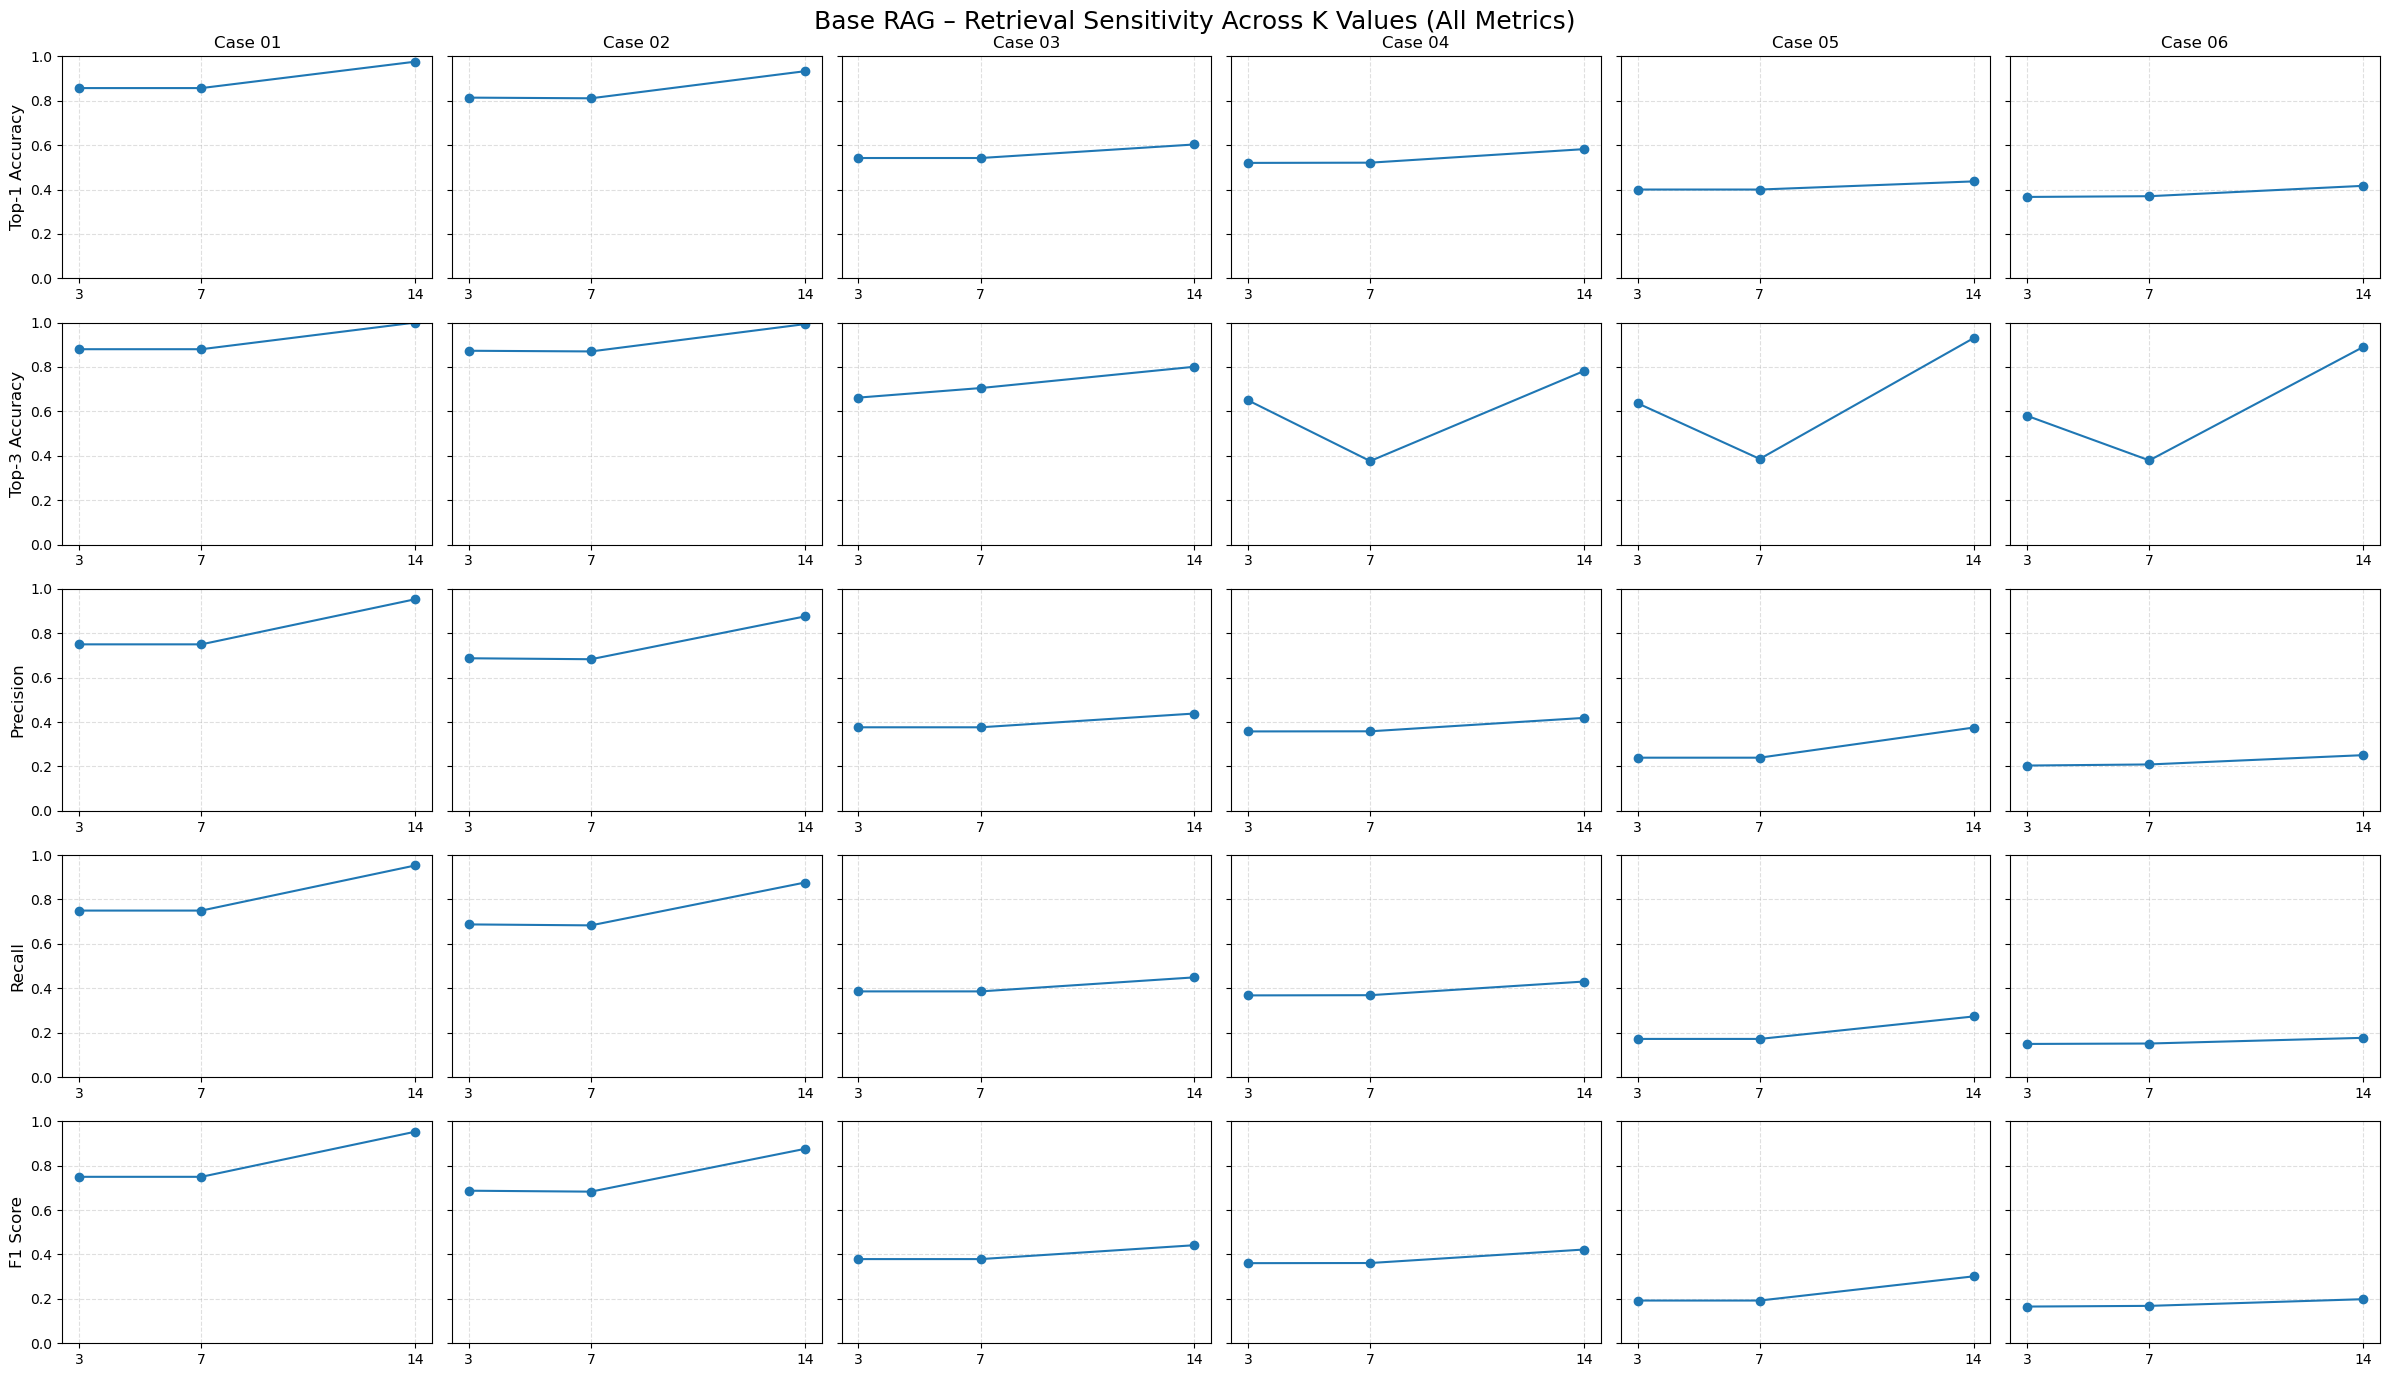

In [28]:
# ------------------------------------------
#  COMBINED SUBPLOT VISUALIZATION
# ------------------------------------------

metrics = ["top1", "top3", "precision", "recall", "f1"]
metric_labels = ["Top-1 Accuracy", "Top-3 Accuracy", "Precision", "Recall", "F1 Score"]
cases = list(data.keys())

fig, axes = plt.subplots(len(metrics), len(cases), figsize=(24, 14), sharey="row")

for row_idx, metric in enumerate(metrics):
    for col_idx, case in enumerate(cases):

        ax = axes[row_idx, col_idx]

        k_vals = data[case]["k"]
        y_vals = data[case][metric]

        ax.plot(k_vals, y_vals, marker="o")

        ax.set_xticks([3, 7, 14])
        ax.set_ylim(0, 1)

        # only left column gets y-label
        if col_idx == 0:
            ax.set_ylabel(metric_labels[row_idx], fontsize=12)

        # title = case name
        if row_idx == 0:
            ax.set_title(case, fontsize=12)

        ax.grid(True, linestyle="--", alpha=0.4)

fig.suptitle("Base RAG – Retrieval Sensitivity Across K Values (All Metrics)", fontsize=18)
plt.tight_layout()
plt.show()

In [29]:
data = {
    "Case 01": {"k":[3,7,14],"top1":[0.857,0.857,0.976],"top3":[0.88,0.88,1.0],
                "precision":[0.7498,0.7498,0.9531],"recall":[0.7498,0.7498,0.9531],"f1":[0.7498,0.7498,0.9531]},

    "Case 02": {"k":[3,7,14],"top1":[0.814,0.811,0.933],"top3":[0.873,0.87,0.993],
                "precision":[0.6871,0.6828,0.8756],"recall":[0.6875,0.6832,0.8761],"f1":[0.6872,0.683,0.8757]},

    "Case 03": {"k":[3,7,14],"top1":[0.542,0.542,0.603],"top3":[0.662,0.705,0.801],
                "precision":[0.3762,0.3762,0.4382],"recall":[0.3858,0.3858,0.449],"f1":[0.3792,0.3792,0.4417]},

    "Case 04": {"k":[3,7,14],"top1":[0.52,0.521,0.582],"top3":[0.65,0.3762,0.782],
                "precision":[0.3576,0.3581,0.4185],"recall":[0.3678,0.3687,0.4302],"f1":[0.3609,0.3615,0.4223]},

    "Case 05": {"k":[3,7,14],"top1":[0.4,0.4,0.4367],"top3":[0.6367,0.3858,0.93],
                "precision":[0.2393,0.2393,0.375],"recall":[0.1717,0.1717,0.2729],"f1":[0.1925,0.1925,0.3015]},

    "Case 06": {"k":[3,7,14],"top1":[0.3667,0.37,0.4167],"top3":[0.58,0.3792,0.89],
                "precision":[0.2039,0.2088,0.2507],"recall":[0.1491,0.151,0.1766],"f1":[0.1654,0.1685,0.1986]},
}

In [30]:
records = []
for case, vals in data.items():
    for i, k in enumerate(vals["k"]):
        records.append({
            "case": case,
            "k": k,
            "top1": vals["top1"][i],
            "top3": vals["top3"][i],
            "precision": vals["precision"][i],
            "recall": vals["recall"][i],
            "f1": vals["f1"][i],
        })

df = pd.DataFrame(records)

metric_cols = ["top1", "top3", "precision", "recall", "f1"]

# Strip whitespace, convert empty strings to NaN, force numeric
for col in metric_cols:
    df[col] = df[col].astype(str).str.strip().replace("", np.nan)
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.dtypes)

df[metric_cols] = df[metric_cols].apply(pd.to_numeric, errors="coerce")

# Compute mean values across all 6 cases
mean_df = df.groupby("k")[metric_cols].mean().reset_index()
print(mean_df)

mean_df.head()

case          object
k              int64
top1         float64
top3         float64
precision    float64
recall       float64
f1           float64
dtype: object
    k      top1      top3  precision    recall        f1
0   3  0.583283  0.713617   0.435650  0.418617  0.422500
1   7  0.583500  0.599367   0.435833  0.418367  0.422417
2  14  0.657900  0.899333   0.551850  0.526317  0.532150


,k,top1,top3,precision,recall,f1
0,3,0.583283,0.713617,0.435650,0.418617,0.422500
1,7,0.583500,0.599367,0.435833,0.418367,0.422417
2,14,0.657900,0.899333,0.551850,0.526317,0.532150


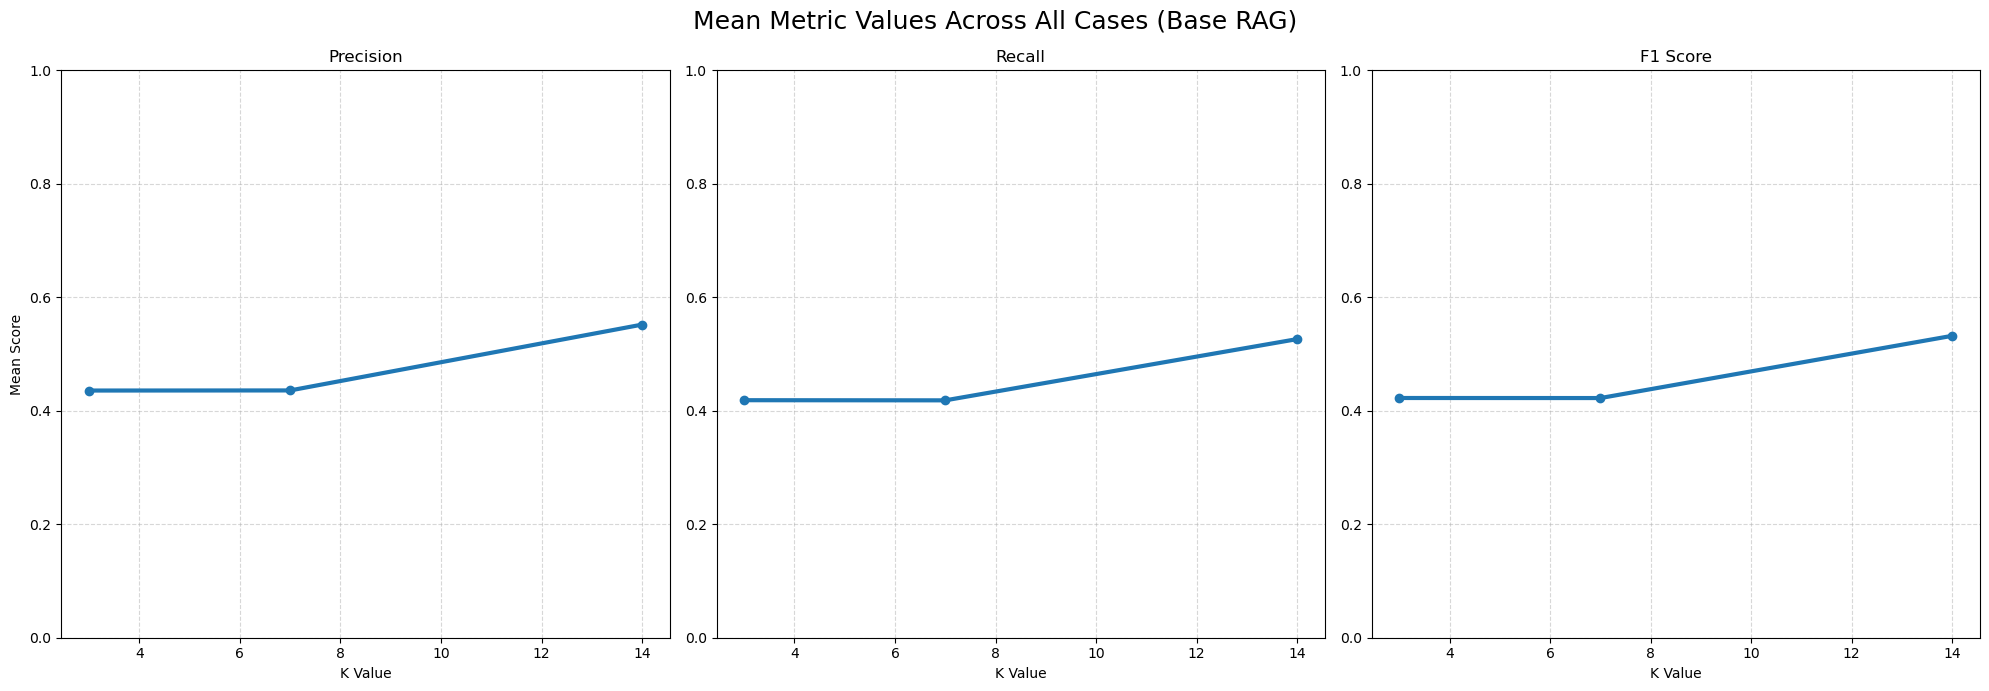

In [31]:
# ------------------------------------------
#  COMBINED SUBPLOT OF MEAN VALUES OVER K
# ------------------------------------------

metrics = ["precision", "recall", "f1"]
metric_labels = ["Precision", "Recall", "F1 Score"]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    ax.plot(mean_df["k"], mean_df[metric], marker="o", linewidth=3)
    ax.set_title(metric_labels[idx], fontsize=12)
    ax.set_xlabel("K Value")
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Only first subplot gets Y label
    if idx == 0:
        ax.set_ylabel("Mean Score")

plt.suptitle("Mean Metric Values Across All Cases (Base RAG)", fontsize=18)
plt.tight_layout()
plt.show()

# RAG with LLM

In [37]:
rag_llm_data = {
    "Case 01": {
        "k": [3, 7, 14],
        "top1":      [0.859, 0.859, 0.980],
        "top3":      [0.880, 0.880, 1.000],     # Top-7 for K7, Top-14 for K14
        "precision": [0.7528, 0.7528, 0.9608],
        "recall":    [0.7528, 0.7528, 0.9608],
        "f1":        [0.7528, 0.7528, 0.9608]
    },

    # "Case 02": {
    #     "k": [3, 7, 14],
    #     "top1":      [0.844, 0.840, 0.963],
    #     "top3":      [0.871, 0.869, 0.993],
    #     "precision": [0.7301, 0.7250, 0.9295],
    #     "recall":    [0.7301, 0.7254, 0.9295],
    #     "f1":        [0.7301, 0.7251, 0.9295]
    # },

    "Case 03": {
        "k": [3, 7, 14],
        "top1":      [0.595, 0.606, 0.683],
        "top3":      [0.662, 0.705, 0.801],
        "precision": [0.4282, 0.4398, 0.5247],
        "recall":    [0.4365, 0.4486, 0.5336],
        "f1":        [0.4309, 0.4426, 0.5276]
    },

    # "Case 04": {
    #     "k": [3, 7, 14],
    #     "top1":      [0.585, 0.600, 0.673],
    #     "top3":      [0.651, 0.686, 0.778],
    #     "precision": [0.4196, 0.4341, 0.5135],
    #     "recall":    [0.4289, 0.4435, 0.5237],
    #     "f1":        [0.4227, 0.4372, 0.5169]
    # },

    "Case 05": {
        "k": [3, 7, 14],
        "top1":      [0.480, 0.490, 0.5567],
        "top3":      [0.6367, 0.7733, 0.6367],
        "precision": [0.3099, 0.3140, 0.3039],
        "recall":    [0.2212, 0.2322, 0.2171],
        "f1":        [0.2464, 0.2548, 0.2416]
    }

    # "Case 06": {
    #     "k": [3, 7, 14],
    #     "top1":      [0.4467, 0.460, 0.5167],
    #     "top3":      [0.590, 0.7233, 0.8933],
    #     "precision": [0.2706, 0.2848, 0.3264],
    #     "recall":    [0.1934, 0.2063, 0.2392],
    #     "f1":        [0.2156, 0.2288, 0.2640]
    # }
}


In [40]:
records = []
for case, vals in data.items():
    for i, k in enumerate(vals["k"]):
        records.append({
            "case": case,
            "k": k,
            "top1": vals["top1"][i],
            "top3": vals["top3"][i],
            "precision": vals["precision"][i],
            "recall": vals["recall"][i],
            "f1": vals["f1"][i],
        })

df02 = pd.DataFrame(records)

metric_cols = ["top1", "top3", "precision", "recall", "f1"]

# Strip whitespace, convert empty strings to NaN, force numeric
for col in metric_cols:
    df02[col] = df02[col].astype(str).str.strip().replace("", np.nan)
    df02[col] = pd.to_numeric(df02[col], errors="coerce")

print(df02.dtypes)

df02[metric_cols] = df02[metric_cols].apply(pd.to_numeric, errors="coerce")

# Compute mean values across all 6 cases
mean_d02 = df02.groupby("k")[metric_cols].mean().reset_index()
print(mean_d02)

mean_d02.head()

case          object
k              int64
top1         float64
top3         float64
precision    float64
recall       float64
f1           float64
dtype: object
    k      top1      top3  precision    recall        f1
0   3  0.583283  0.713617   0.435650  0.418617  0.422500
1   7  0.583500  0.599367   0.435833  0.418367  0.422417
2  14  0.657900  0.899333   0.551850  0.526317  0.532150


,k,top1,top3,precision,recall,f1
0,3,0.583283,0.713617,0.435650,0.418617,0.422500
1,7,0.583500,0.599367,0.435833,0.418367,0.422417
2,14,0.657900,0.899333,0.551850,0.526317,0.532150


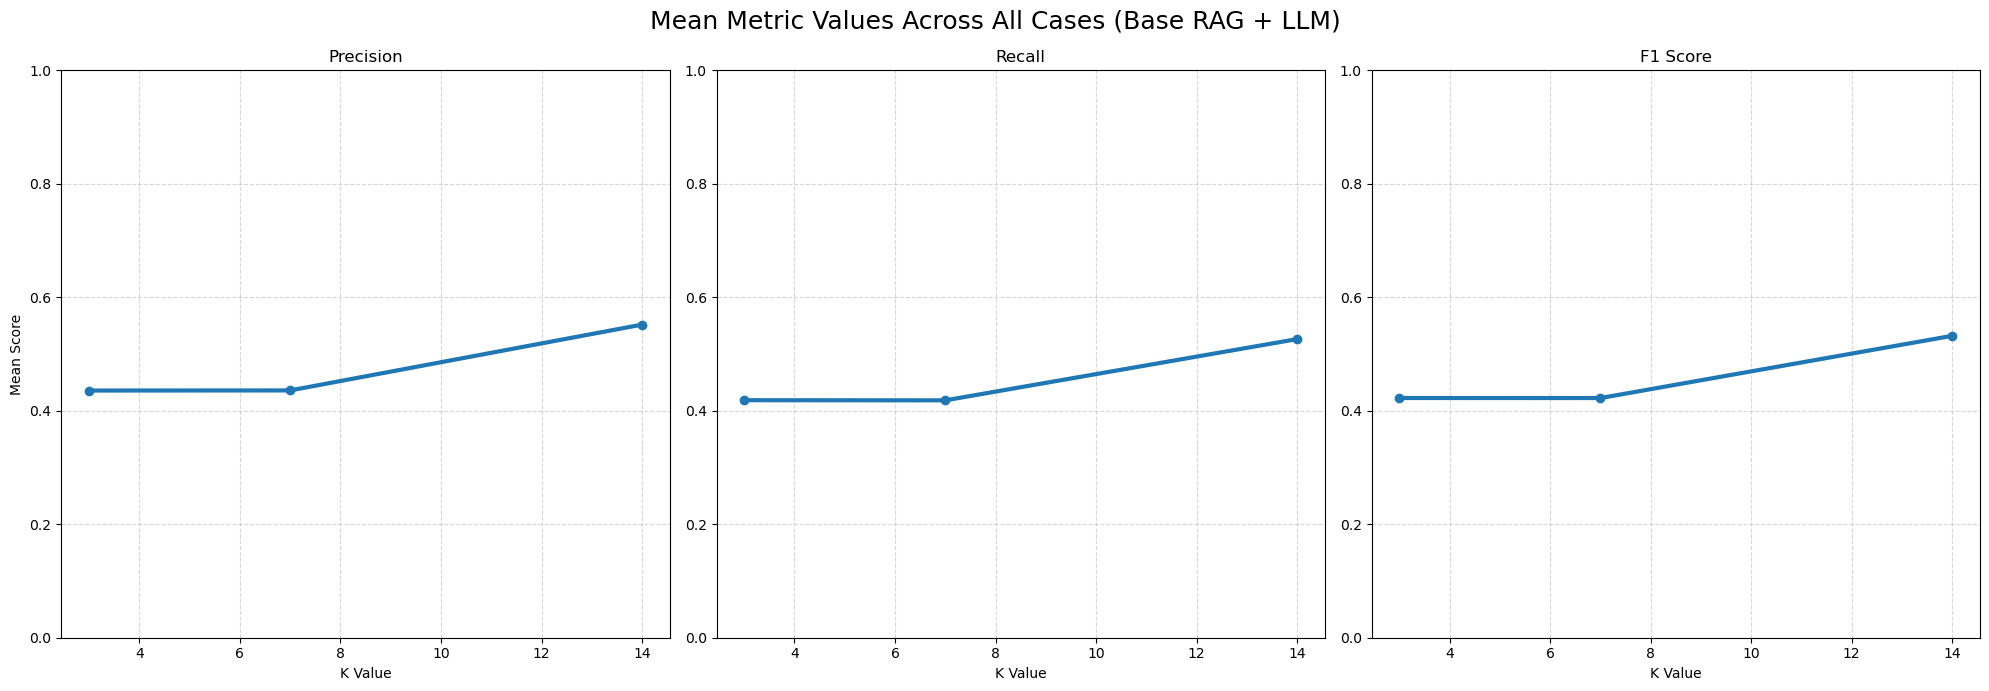

In [41]:
# ------------------------------------------
#  COMBINED SUBPLOT OF MEAN VALUES OVER K
# ------------------------------------------

metrics = ["precision", "recall", "f1"]
metric_labels = ["Precision", "Recall", "F1 Score"]

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    ax.plot(mean_d02["k"], mean_d02[metric], marker="o", linewidth=3)
    ax.set_title(metric_labels[idx], fontsize=12)
    ax.set_xlabel("K Value")
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Only first subplot gets Y label
    if idx == 0:
        ax.set_ylabel("Mean Score")

plt.suptitle("Mean Metric Values Across All Cases (Base RAG + LLM)", fontsize=18)
plt.tight_layout()
plt.show()

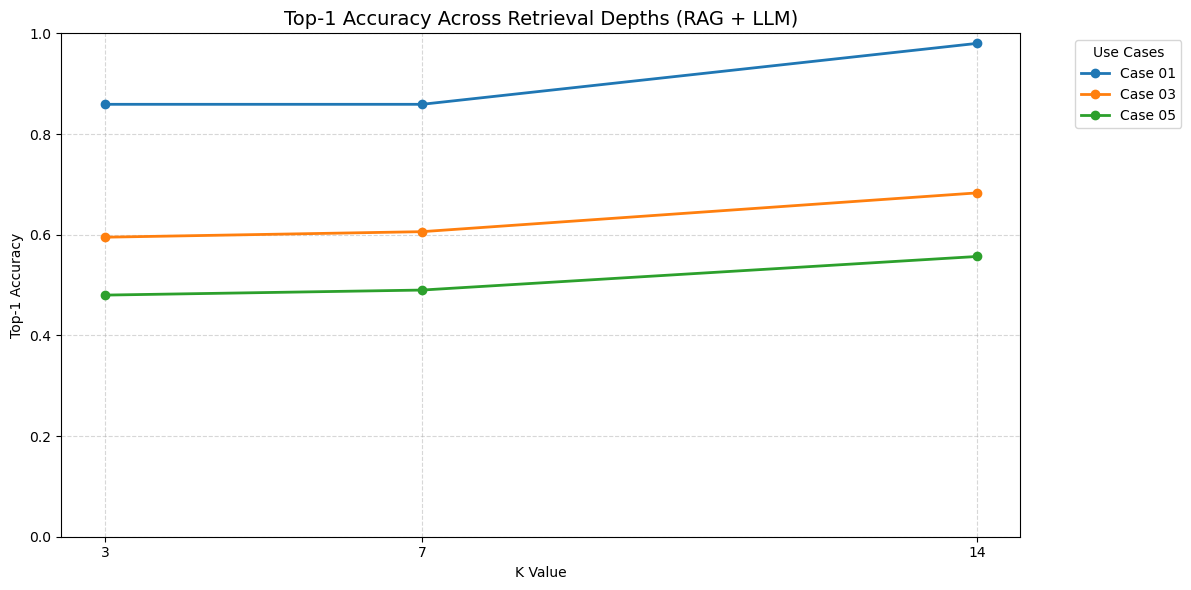

In [42]:
cases = list(rag_llm_data.keys())
k_vals = [3, 7, 14]

plt.figure(figsize=(12, 6))

for case in cases:
    y_vals = rag_llm_data[case]["top1"]
    plt.plot(k_vals, y_vals, marker="o", linewidth=2, label=case)

plt.title("Top-1 Accuracy Across Retrieval Depths (RAG + LLM)", fontsize=14)
plt.xlabel("K Value")
plt.ylabel("Top-1 Accuracy")
plt.xticks(k_vals)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Use Cases", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

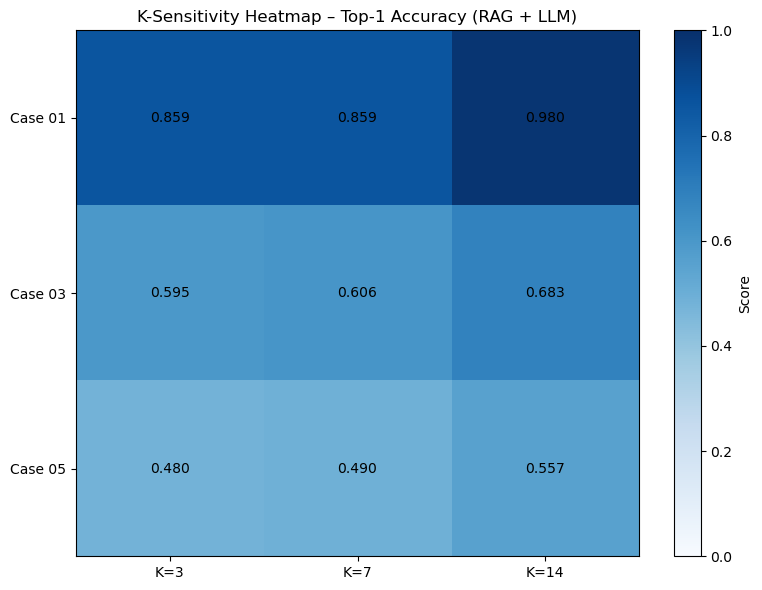

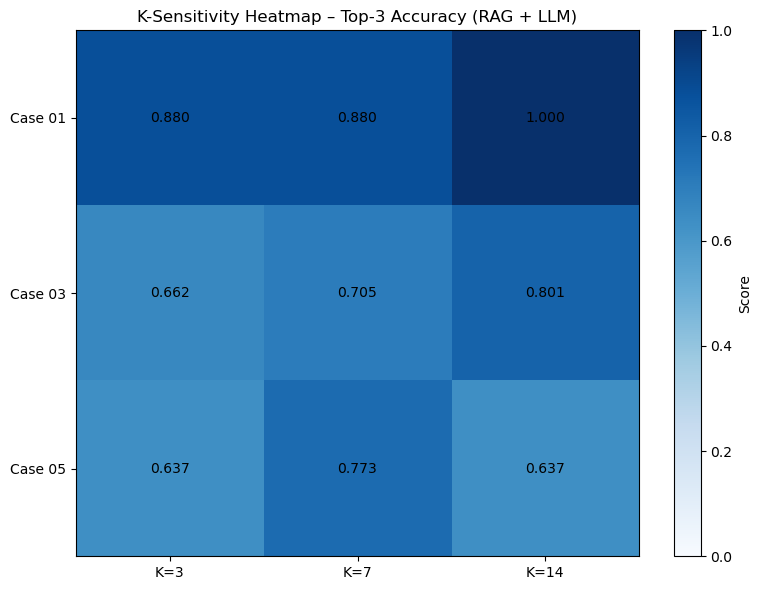

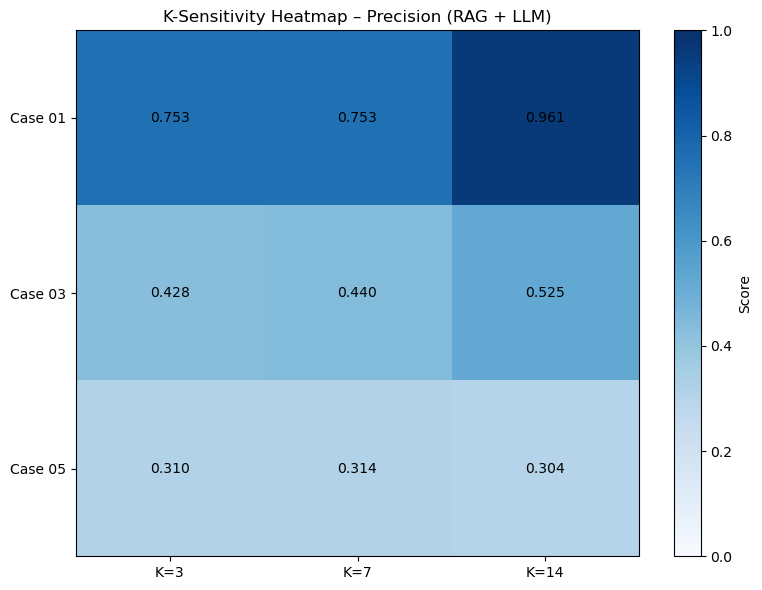

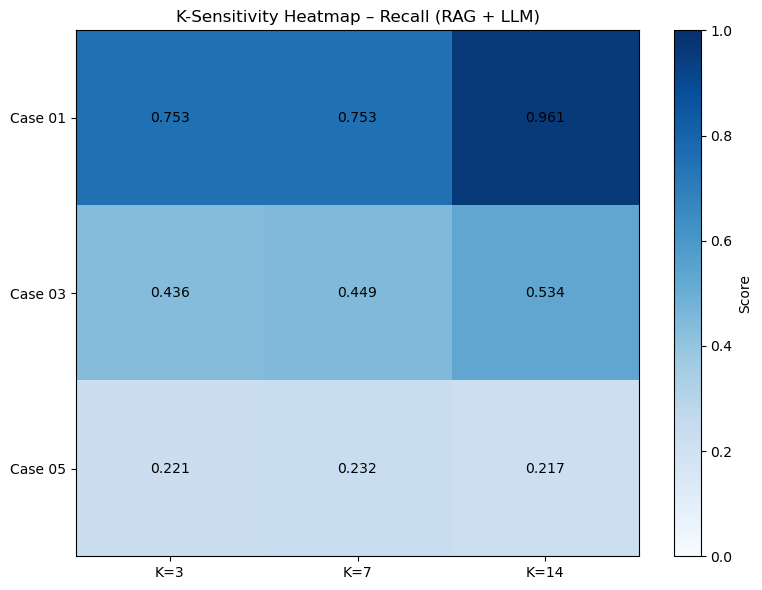

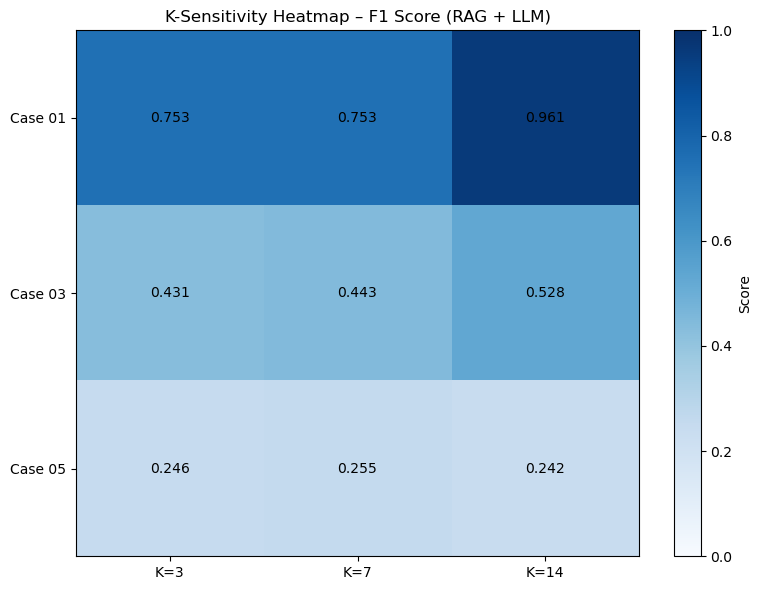

In [43]:
metrics = ["top1", "top3", "precision", "recall", "f1"]
metric_labels = ["Top-1 Accuracy", "Top-3 Accuracy", "Precision", "Recall", "F1 Score"]
cases = list(rag_llm_data.keys())
k_vals = [3, 7, 14]

for idx, metric in enumerate(metrics):
    # Build matrix for heatmap
    heat_data = []
    for case in cases:
        heat_data.append(rag_llm_data[case][metric])
    
    heat_data = np.array(heat_data)

    plt.figure(figsize=(8, 6))
    plt.imshow(heat_data, cmap="Blues", aspect="auto", vmin=0, vmax=1)

    plt.title(f"K-Sensitivity Heatmap – {metric_labels[idx]} (RAG + LLM)")
    plt.xticks([0, 1, 2], ["K=3", "K=7", "K=14"])
    plt.yticks(range(len(cases)), cases)
    plt.colorbar(label="Score")

    # Add values inside cells
    for i in range(len(cases)):
        for j in range(3):
            plt.text(j, i, f"{heat_data[i,j]:.3f}", ha="center", va="center")

    plt.tight_layout()
    plt.show()
